In [1]:
from __future__ import print_function

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from VideoDataset import VideoDataset
from Generator import Generator
from Discriminator import Discriminator

import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.utils as vutils


In [2]:
# Set random seed for reproducibility
manualSeed = 69
#manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)

workers = 1 # Number of workers for dataloader
batch_size = 128 * 2 # Batch size during training
image_size = 64 #image size in the model
nc = 3 # Number of channels in the training images. For color images this is 3
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 5 # Number of training epochs
lr = 0.00002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
ngpu = 1 # Number of GPUs available. Use 0 for CPU mode.

In [11]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
dataset = VideoDataset("data/s01ep01.mkv", image_size)
dataloader = DataLoader(dataset, batch_size=batch_size)

# Create the generator and Discriminator
netG = Generator(ngpu, device, nz, ngf, nc).to(device)
netD = Discriminator(ngpu, device, nc, ndf).to(device)

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr)
optimizerG = optim.Adam(netG.parameters(), lr=lr)

# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

cuda:0


In [12]:
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    print(epoch)
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data["img"].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 5 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 10 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

0
[0/5][0/117]	Loss_D: 0.8110	Loss_G: 1.4407	D(x): 0.9694	D(G(z)): 0.5194 / 0.2604
1
[1/5][0/117]	Loss_D: 0.8076	Loss_G: 1.3861	D(x): 0.9383	D(G(z)): 0.4742 / 0.2938
2
[2/5][0/117]	Loss_D: 1.9406	Loss_G: 0.8668	D(x): 0.4646	D(G(z)): 0.5840 / 0.4644
3
[3/5][0/117]	Loss_D: 2.1400	Loss_G: 1.1725	D(x): 0.2333	D(G(z)): 0.4241 / 0.3403
4
[4/5][0/117]	Loss_D: 1.5363	Loss_G: 0.8295	D(x): 0.5754	D(G(z)): 0.5571 / 0.4632


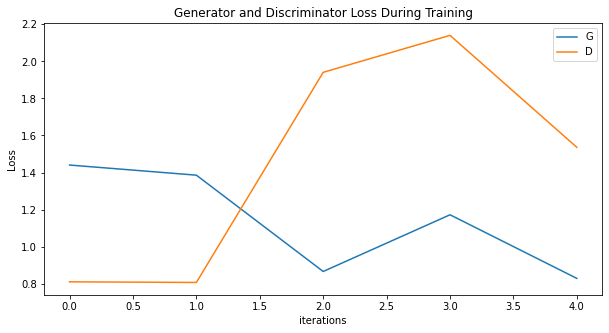

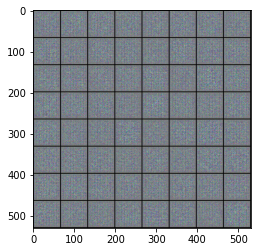

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

for img in img_list:
    plt.imshow(img.cpu().numpy().transpose(2, 1, 0))

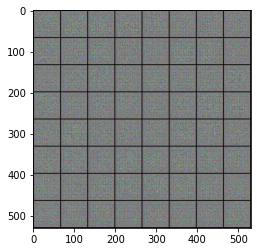